<a href="https://colab.research.google.com/github/sramakrishnan247/Sentence-Similarity/blob/main/BERTPlay_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERTPlay - A semantic similarity checking project**
***- By Ramakrishnan Sundareswaran, Kumara Sri Harsha Vajjhala***

In this project, we build and experiment with different deep learning models to predict the semantic similarity between two sentences. Semantic similarity prediction task requires a deep understanding of the language, and hence, we require complex models which create word embeddings based on the context in which it is used. We explore two of the most successful architectures in NLP: BERT, and a bi-directional LSTM and compare their performance. 

The common dataset used to train all the models is : Stanford Natural Language Inference (SNLI). We have also experimented with a BERT-large pre-trained on SQuAD (Stanford Question Answering Dataset)

We have used the colab notebook by Mohammed Merchant : https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/semantic_similarity_with_bert.ipynb#scrollTo=w60qwFa1dWEB as a reference while creating our BERT models. 

We have also optimized our models using the best optimizing strategies to get excellent results.

# About BERT

BERT(Bidirectional Encoder Representations from Transformers) is a Transformer-based architecture used for Natural Language processing tasks. Prior to BERT, the state of the art NLP models used LSTM (Long Short Term Memory), which are a certain kind of recurrent neural networks that are slow and not completely bi-directional. This led to the invention of Transformers, that are relatively faster, and can accomodate context-aware word embeddings. BERT stacks a number of encoders to acheive excellent results in question answering, semantic similarity, text classification, etc. 

# Architecture of BERT

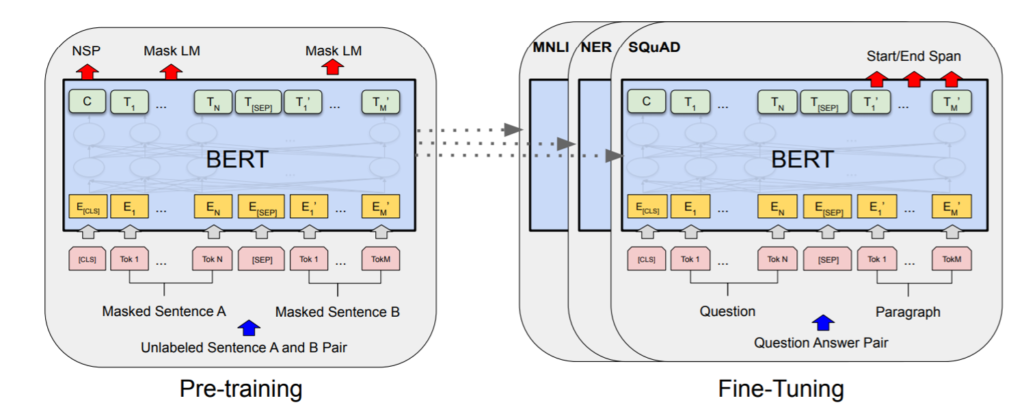

BERT is an encoder stack of transformer architecture. BERT-base has 12 layers in the Encoder stack while BERT-large has 24 layers in the Encoder stack. Bert-base has 110M parameters, while Bert-large has 340M parameters.

BERT trains on two unsupervised tasks simultaneously. These tasks are the Masked Language Model (MLM) and Next Sentence Prediction (NSP). For MLM, It takes in a sentence with random words filled with masks, and the goal is to understand these masked tokens and assign corresponding words by understanding bidirectional context within a sentence. 

In the case of NSP, BERT takes in two sentences and returns if the second sentence follows from thefirst in a manner similar to a binary classification. More specifically, the inputs are fed in the form of pretrained embeddings. The BERT paper combines token embeddings, segment embeddings and position embeddings which are combined and fed as the input. The segment and position embedding are required for temporal understanding, and all these vectors are fed in simultaneously. This helps BERT understand context and thus, using these two BERT understands language in a deeper sense.


# BERT Finetuning

Finetuning a BERT model is the task of training the pre-trained model of BERT with the specific problem in hand. This is generally done by training the output layer of our model separately (linear/ LSTM), and adding it to BERT and re-training the entire network.

In this project, we have tried using Linear and LSTM as the output layer.

# Common Tasks (Run them before running any model)

## 1. Import the required libraries

In [2]:
!pip install transformers

import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import transformers

     |████████████████████████████████| 1.3MB 19.5MB/s 
     |████████████████████████████████| 890kB 46.0MB/s 
     |████████████████████████████████| 2.9MB 53.3MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=088a83271ce54ae8e0751fb01bcd5fbdc27f01cad61959fc0bfefc80f14662ec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## 2. Download the SNLI dataset

In this step, we download the SNLI dataset, extract it into the train, validation and test csv files

In [3]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  31.4M      0 --:--:-- --:--:-- --:--:-- 31.3M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


## 3. Load the datasets into pandas dataframes

In [4]:

train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Total train samples : 100000
Total validation samples: 10000
Total test samples: 10000
Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


## 4. Clean the data

In [5]:
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)
print("Train Target Distribution")
print(train_df.similarity.value_counts())
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64
Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64
Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


In [6]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

## 5. Create labels for the train, validation and test datasets

In [7]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

## 6. Sentence similarity verification method

In [20]:
def is_similar(sentence1, sentence2, model, tokenizer):
    '''
    Takes a sentence1 and checks if sentence2 is symantically similar to sentence1.
    '''
    sent = [sentence1,sentence2]
    
    encoded = tokenizer([sent], return_tensors='pt',add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            )

    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

    x_train = [input_ids, attention_masks, token_type_ids]
    # y_train = tf.keras.utils.to_categorical(train_df[0].label, num_classes=3)

    y_pred = np.array(model.predict(x_train))[0]
    print(y_pred)
    idx = np.argmax(y_pred)
    sentiment_labels = ["contradiction", "entailment", "neutral"]
    print(idx)
    print(sentiment_labels[idx])
    print(y_pred[idx])

# Model 1 : Plain BERT(small)

## 1. Create BERT tokenizer

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )

## 2. Encode the train data using BERT tokenizer

In [ ]:
max_length = 128

x_train = train_df[["sentence1", "sentence2"]].values.astype("str")

encoded = tokenizer(x_train[0:100000].tolist(), return_tensors='pt', add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            )


#Embedding and stuff
input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_train = [input_ids, attention_masks, token_type_ids]
y_train = tf.keras.utils.to_categorical(train_df[0:100000].label, num_classes=3)


# Encoded token ids from BERT tokenizer.
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)


#Encode the validation set
encoded_valid = tokenizer(valid_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids_valid = np.array(encoded_valid["input_ids"], dtype="int32")
attention_masks_valid = np.array(encoded_valid["attention_mask"], dtype="int32")
token_type_ids_valid = np.array(encoded_valid["token_type_ids"], dtype="int32")

x_valid = [input_ids_valid, attention_masks_valid, token_type_ids_valid]
y_valid = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

valid_data = x_valid,y_valid

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 3. Load the BERT pre-trained model

In [ ]:
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")

# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False

sequence_output, pooled_output = bert_model(
  input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

sequence_output = tf.keras.layers.Flatten()(sequence_output)
output = tf.keras.layers.Dense(3, activation="softmax")(sequence_output)
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["acc"],
)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0] 

## 4. Train the model

In [ ]:
training_history = model.fit(x_train,y_train,validation_data=valid_data,epochs=2,batch_size=16, verbose=1)

Epoch 1/2
6243/6243 [==============================] - 1093s 175ms/step - loss: 4.1711 - acc: 0.5355 - val_loss: 3.8692 - val_acc: 0.6167
Epoch 2/2
6243/6243 [==============================] - 1104s 177ms/step - loss: 4.3283 - acc: 0.5843 - val_loss: 4.2993 - val_acc: 0.6347


## 5. Save the model (Optional)

In [ ]:
model.save_weights('BERT_Plain.h5')

## 6. Verify the model performance

In [ ]:
is_similar("Charlie went to the cycle shop on Sunday","Charlie was resting at home on Sunday", model)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[5.3576505e-01 2.0653822e-11 4.6423498e-01]
0
contradiction
0.53576505


## 7. Test the model

In [ ]:
encoded = tokenizer(test_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_test = [input_ids, attention_masks, token_type_ids]
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

model.evaluate(x_test,y_test, verbose=1)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


313/313 [==============================] - 89s 283ms/step - loss: 4.4134 - acc: 0.6278


[4.413364887237549, 0.6277999877929688]

## 8. Metrics

313/313 [==============================] - 89s 284ms/step
Confusion Matrix:

[[2414  612  211]
 [ 475 2704  189]
 [1244  991 1160]]


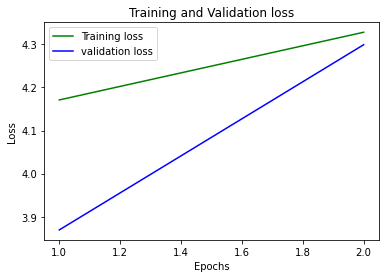

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = model.predict(x_test, verbose=1)

print("Confusion Matrix:\n")
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


loss_train = training_history.history['loss']
loss_val = training_history.history['val_loss']
epochs = np.arange(1,3)
plt.plot(epochs, np.array(loss_train), 'g', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model 2 : Bi-directional LSTM

## 1. Create word embeddings

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-28 10:55:47--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  81.0MB/s    in 22s     

2020-11-28 10:56:10 (70.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



## 2. Create the model and run it

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

EMBEDDING_FILE  = 'GoogleNews-vectors-negative300.bin.gz'
TRAIN_DATA_FILE = "SNLI_Corpus/snli_1.0_train.csv"
TEST_DATA_FILE  = "SNLI_Corpus/snli_1.0_test.csv"
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

def text_to_tokens(text):
    return text.lower()

def get_label_index_mapping():
    return {"neutral": 0, "contradiction": 1, "entailment": 2, "-": 3}
    
def create_embedding_matrix(word_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))+1
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in word2vec.vocab:
            embedding_matrix[i] = word2vec.word_vec(word)
    return embedding_matrix

def load_data():
    train_df = pd.read_csv(TRAIN_DATA_FILE, sep=",", usecols=["sentence1", "sentence2", "similarity"], dtype={"sentence1": str, "sentence2": str, "similarity": str})
    train_df.fillna("", inplace=True)
    sentence1 = train_df["sentence1"].apply(text_to_tokens)
    sentence2 = train_df["sentence2"].apply(text_to_tokens)
    y = train_df["similarity"].map(get_label_index_mapping())
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(sentence1 + sentence2)
    sequences1 = tokenizer.texts_to_sequences(sentence1)
    sequences2 = tokenizer.texts_to_sequences(sentence2)
    X1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)
    X2 = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH)
    perm = np.random.permutation(len(X1))
    num_train   = int(len(X1)*(1-VALIDATION_SPLIT))
    train_index = perm[:num_train]
    valid_index = perm[num_train:]
    X1_train    = X1[train_index]
    X2_train    = X2[train_index]
    y_train     = y[train_index]
    X1_valid    = X1[valid_index]
    X2_valid    = X2[valid_index]
    y_valid     = y[valid_index]
    return (X1_train, X2_train, y_train), (X1_valid, X2_valid, y_valid), tokenizer

def StaticEmbedding(embedding_matrix):
    input_dim, output_dim = embedding_matrix.shape
    return Embedding(input_dim,
            output_dim,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False)
    
def entail(feat1, feat2, num_dense=300):
    x = concatenate([feat1, feat2])
    x = Dropout(rate_drop_dense)(x)
    x = BatchNormalization()(x)
    x = Dense(num_dense, activation="relu")(x)
    x = Dropout(rate_drop_dense)(x)
    x = BatchNormalization()(x)
    return x

def build_model(output_dim, embedding_matrix, num_lstm=300):
    sequence1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    sequence2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
   
    # Embedding
    embed = StaticEmbedding(embedding_matrix)
    embedded_sequences1 = embed(sequence1_input)
    embedded_sequences2 = embed(sequence2_input)
    
    # Encoding
    encode = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)
    feat1 = encode(embedded_sequences1)
    feat2 = encode(embedded_sequences2)
   
    x = entail(feat1, feat2)
    preds = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs=[sequence1_input, sequence2_input], outputs=preds)
    return model

def run():
    num_class = len(get_label_index_mapping())
    (X1_train, X2_train, y_train), (X1_valid, X2_valid, y_valid), tokenizer = load_data()
    Y_train, Y_valid = to_categorical(y_train, num_class), to_categorical(y_valid, num_class)
    embedding_matrix = create_embedding_matrix(tokenizer.word_index) 
    model = build_model(output_dim=num_class, embedding_matrix=embedding_matrix) 
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    hist = model.fit([X1_train, X2_train], Y_train,
            validation_data=([X1_valid, X2_valid], Y_valid),
            epochs=20, batch_size=2048, shuffle=True,
            callbacks=[early_stopping])

if __name__ == "__main__":
    run()

Epoch 1/20
242/242 [==============================] - 88s 363ms/step - loss: 1.0785 - acc: 0.5303 - val_loss: 1.0025 - val_acc: 0.5233
Epoch 2/20
242/242 [==============================] - 88s 365ms/step - loss: 0.8565 - acc: 0.6141 - val_loss: 0.8371 - val_acc: 0.6185
Epoch 3/20
242/242 [==============================] - 88s 365ms/step - loss: 0.8016 - acc: 0.6476 - val_loss: 0.7415 - val_acc: 0.6801
Epoch 4/20
242/242 [==============================] - 89s 367ms/step - loss: 0.7619 - acc: 0.6711 - val_loss: 0.6997 - val_acc: 0.7030
Epoch 5/20
242/242 [==============================] - 89s 369ms/step - loss: 0.7321 - acc: 0.6873 - val_loss: 0.6765 - val_acc: 0.7155
Epoch 6/20
242/242 [==============================] - 89s 368ms/step - loss: 0.7112 - acc: 0.6989 - val_loss: 0.6507 - val_acc: 0.7314
Epoch 7/20
242/242 [==============================] - 89s 367ms/step - loss: 0.6943 - acc: 0.7080 - val_loss: 0.6460 - val_acc: 0.7302
Epoch 8/20
242/242 [==============================] - 8

# Model 3 : BERT-large pre-trained on SQuAD

## 1. Create BERT-large tokenizer

In [9]:
tokenizer_bl = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad', do_lower_case=True)

## 2. Encode the train data using BERT-large tokenizer

In [10]:
max_length = 128

x_train = train_df[["sentence1", "sentence2"]].values.astype("str")

encoded = tokenizer_bl(x_train[0:100000].tolist(), return_tensors='pt', add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            )


#Embedding and stuff
input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_train = [input_ids, attention_masks, token_type_ids]
y_train = tf.keras.utils.to_categorical(train_df[0:100000].label, num_classes=3)


# Encoded token ids from BERT tokenizer.
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)


#Encode the validation set
encoded_valid = tokenizer_bl(valid_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids_valid = np.array(encoded_valid["input_ids"], dtype="int32")
attention_masks_valid = np.array(encoded_valid["attention_mask"], dtype="int32")
token_type_ids_valid = np.array(encoded_valid["token_type_ids"], dtype="int32")

x_valid = [input_ids_valid, attention_masks_valid, token_type_ids_valid]
y_valid = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

valid_data = x_valid,y_valid

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 3. Load the BERT-large pre-trained model

In [11]:
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False

sequence_output, pooled_output = bert_model(
  input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
bi_lstm = tf.keras.layers.Bidirectional(
tf.keras.layers.LSTM(64, return_sequences=True)
)(sequence_output)

# Applying hybrid pooling approach to bi_lstm sequence output.
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)

output = tf.keras.layers.Dense(3, activation="softmax")(dropout)

model_bl = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model_bl.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["acc"],
)
model_bl.summary()

Some layers from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing TFBertModel: ['qa_outputs']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 1024),  335141888   input_ids[0][0]                  
                                                                 attention_masks[0][0] 

## 4. Train the model

In [12]:
training_history = model_bl.fit(x_train,y_train,validation_data=valid_data,epochs=2,batch_size=16, verbose=1)

Epoch 1/2
6243/6243 [==============================] - 3323s 532ms/step - loss: 0.7092 - acc: 0.6970 - val_loss: 0.5236 - val_acc: 0.8023
Epoch 2/2
6243/6243 [==============================] - 3329s 533ms/step - loss: 0.6277 - acc: 0.7438 - val_loss: 0.4929 - val_acc: 0.8092


## 5. Finetune the model

In [13]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model_bl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_bl.summary()

finetuning_history = model_bl.fit(x_train,y_train, validation_data=valid_data, epochs=2,batch_size=16)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 1024),  335141888   input_ids[0][0]                  
                                                                 attention_masks[0][0] 

## 6. Save the model (Optional)

In [14]:
model_bl.save_weights('BERT_large_SQuAD.h5')

## 7. Verify the model performance

In [23]:
is_similar("Any trip to Italy should include a visit to Tuscany to sample the region's exquisite wines.","Be sure to make time for a Tuscan wine-tasting experience when visiting Italy.", model_bl, tokenizer_bl)

[0.01231802 0.7330076  0.2546743 ]
1
entailment
0.7330076


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 8. Test the model

In [16]:
encoded = tokenizer_bl(test_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_test = [input_ids, attention_masks, token_type_ids]
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

model_bl.evaluate(x_test,y_test, verbose=1)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


313/313 [==============================] - 281s 898ms/step - loss: 0.3264 - accuracy: 0.8827


[0.32644084095954895, 0.8827000260353088]

## 9. Metrics

313/313 [==============================] - 283s 903ms/step
Confusion Matrix:

[[2938   91  208]
 [  62 3058  248]
 [ 224  340 2831]]


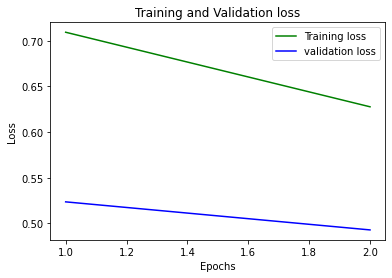

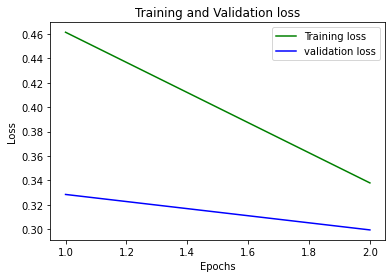

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = model_bl.predict(x_test, verbose=1)

print("Confusion Matrix:\n")
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


loss_train = training_history.history['loss']
loss_val = training_history.history['val_loss']
epochs = np.arange(1,3)
plt.plot(epochs, np.array(loss_train), 'g', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


loss_train = finetuning_history.history['loss']
loss_val = finetuning_history.history['val_loss']
epochs = np.arange(1,3)
plt.plot(epochs, np.array(loss_train), 'g', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 4 : Plain BERT(small) with Bi-Directional LSTM for finetuning

## 1. Create BERT tokenizer

In [24]:
tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )

## 2. Encode the train data using BERT tokenizer

In [26]:
max_length = 128

x_train = train_df[["sentence1", "sentence2"]].values.astype("str")

encoded = tokenizer(x_train[0:100000].tolist(), return_tensors='pt', add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            )


#Embedding and stuff
input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_train = [input_ids, attention_masks, token_type_ids]
y_train = tf.keras.utils.to_categorical(train_df[0:100000].label, num_classes=3)


# Encoded token ids from BERT tokenizer.
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)


#Encode the validation set
encoded_valid = tokenizer(valid_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids_valid = np.array(encoded_valid["input_ids"], dtype="int32")
attention_masks_valid = np.array(encoded_valid["attention_mask"], dtype="int32")
token_type_ids_valid = np.array(encoded_valid["token_type_ids"], dtype="int32")

x_valid = [input_ids_valid, attention_masks_valid, token_type_ids_valid]
y_valid = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

valid_data = x_valid,y_valid

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 3. Load the BERT pre-trained model

In [27]:
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")

# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False

sequence_output, pooled_output = bert_model(
  input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
bi_lstm = tf.keras.layers.Bidirectional(
tf.keras.layers.LSTM(256, return_sequences=True)
)(sequence_output)

# Applying hybrid pooling approach to bi_lstm sequence output.
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.2)(concat)

output = tf.keras.layers.Dense(3, activation="softmax")(dropout)

model_ft = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["acc"],
)
model_ft.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0] 

## 4. Train the model

In [28]:
training_history = model_ft.fit(x_train,y_train,validation_data=valid_data,epochs=2,batch_size=16, verbose=1)

Epoch 1/2
6243/6243 [==============================] - 1228s 197ms/step - loss: 0.6517 - acc: 0.7248 - val_loss: 0.5049 - val_acc: 0.8002
Epoch 2/2
6243/6243 [==============================] - 1222s 196ms/step - loss: 0.5699 - acc: 0.7681 - val_loss: 0.5088 - val_acc: 0.7995


## 5. Finetune the model

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_ft.summary()

finetuning_history = model_ft.fit(x_train,y_train, validation_data=valid_data, epochs=2,batch_size=16)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0] 

## 6. Save the model (Optional)

In [ ]:
model_ft.save_weights('BERT_Finetuned_Experiment1.h5')

## 7. Verify the model performance

In [ ]:
is_similar("Charlie went to the cycle shop on Sunday","Charlie was resting at home on Sunday", model_ft, tokenizer)

## 8. Test the model

In [ ]:
encoded = tokenizer(test_df[["sentence1", "sentence2"]].values.astype("str").tolist(), return_tensors='pt',
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        )

input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

x_test = [input_ids, attention_masks, token_type_ids]
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

model_ft.evaluate(x_test,y_test, verbose=1)

## 9. Metrics

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = model_ft.predict(x_test, verbose=1)

print("Confusion Matrix:\n")
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


loss_train = training_history.history['loss']
loss_val = training_history.history['val_loss']
epochs = np.arange(1,3)
plt.plot(epochs, np.array(loss_train), 'g', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


loss_train = finetuning_history.history['loss']
loss_val = finetuning_history.history['val_loss']
epochs = np.arange(1,2)
plt.plot(epochs, np.array(loss_train), 'g', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Experiments

**Experiment 1** : Plain Bert(Small) with Bi-directional LSTM for finetuning

 -  Changed number of LSTM nodes of the output layer from 64 to 128
 - Increased dropout rate to 0.35


 Results: 

 After Training: 
                  
                  loss: 0.5971 - acc: 0.7559 
                  val_loss: 0.5043 - val_acc: 0.8027

After Finetuning:

                loss: 0.4692 - accuracy: 0.8173
                val_loss: 0.3623 - val_accuracy: 0.8683

Test data:
                
                loss: 0.3819 - accuracy: 0.8587


**Experiment 2** : Plain Bert(Small) with Bi-directional LSTM for finetuning

 -  Changed number of LSTM nodes of the output layer from 64 to 128
 - Increased dropout rate to 0.35


 Results: 

 After Training: 
                  
                  loss: 0.5971 - acc: 0.7559 
                  val_loss: 0.5043 - val_acc: 0.8027

After Finetuning:

                loss: 0.4692 - accuracy: 0.8173
                val_loss: 0.3623 - val_accuracy: 0.8683

Test data:
                
                loss: 0.3819 - accuracy: 0.8587


**Experiment 3** : Plain Bert(Small) with Bi-directional LSTM for finetuning

 -  Changed number of LSTM nodes of the output layer from 64 to 128
 - Increased dropout rate to 0.35


 Results: 

 After Training: 
                  
                  loss: 0.5971 - acc: 0.7559 
                  val_loss: 0.5043 - val_acc: 0.8027

After Finetuning:

                loss: 0.4692 - accuracy: 0.8173
                val_loss: 0.3623 - val_accuracy: 0.8683

Test data:
                
                loss: 0.3819 - accuracy: 0.8587


**Experiment 4** : Plain Bert(Small) with Bi-directional LSTM for finetuning

 -  Changed number of LSTM nodes of the output layer from 64 to 128
 - Increased dropout rate to 0.35


 Results: 

 After Training: 
                  
                  loss: 0.5971 - acc: 0.7559 
                  val_loss: 0.5043 - val_acc: 0.8027

After Finetuning:

                loss: 0.4692 - accuracy: 0.8173
                val_loss: 0.3623 - val_accuracy: 0.8683

Test data:
                
                loss: 0.3819 - accuracy: 0.8587


**Experiment 5** : Plain Bert(Small) with Bi-directional LSTM for finetuning

 -  Changed number of LSTM nodes of the output layer from 64 to 128
 - Increased dropout rate to 0.35


 Results: 

 After Training: 
                  
                  loss: 0.5971 - acc: 0.7559 
                  val_loss: 0.5043 - val_acc: 0.8027

After Finetuning:

                loss: 0.4692 - accuracy: 0.8173
                val_loss: 0.3623 - val_accuracy: 0.8683

Test data:
                
                loss: 0.3819 - accuracy: 0.8587


# Conclusion

From the above experiments, we observed that the Plain BERT(Small) with Bidirectional LSTM for Finetuning (Experiment 1) was performing the best. It was underfitting the data, because the training accuracy was less than the test and validation set accuracy. So, there is scope for further training of the model, maybe adding 2 or more epochs would help. By doing so, we will achieve a better accuracy, with the drawback of increased training time. 

We have used this model in our two games (SemanticSimilarityGame.ipynb and ReadingComprehensionGame.ipynb) , and achieved a great gameplay experience.